<a href="https://colab.research.google.com/github/Emaankanwal8/Deep-learning-models/blob/main/pneumonia_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

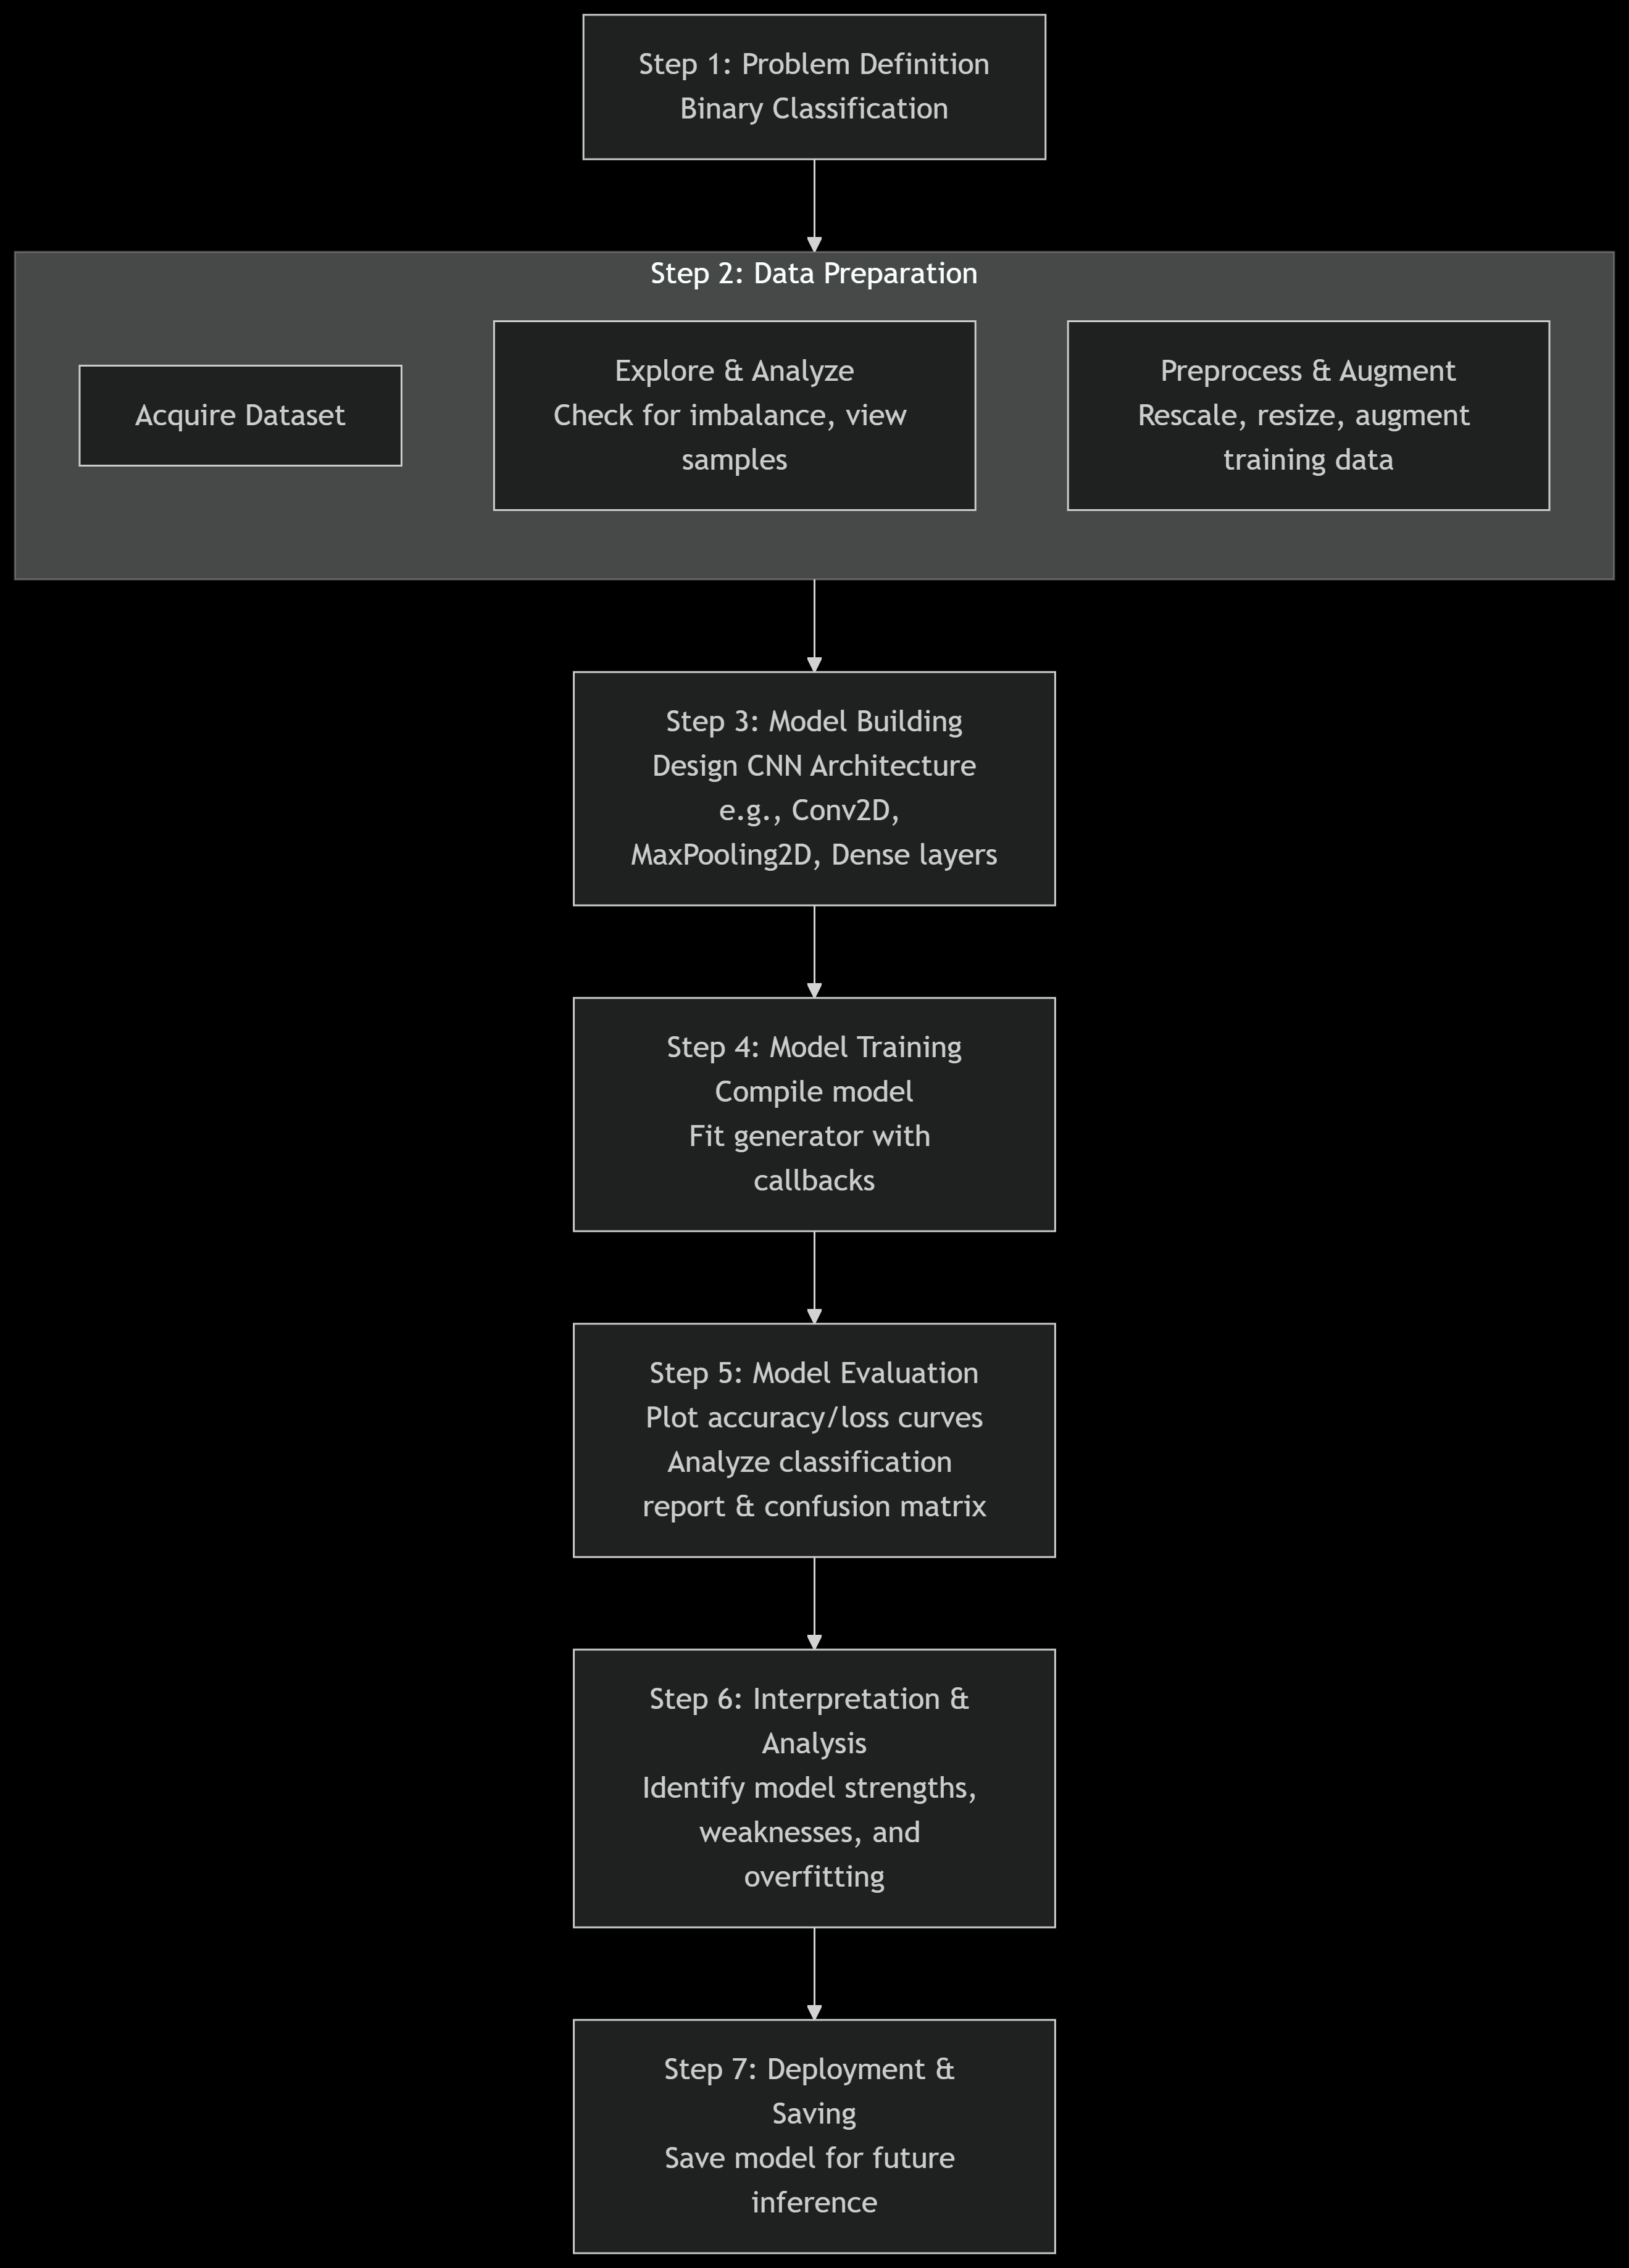

In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emaankanwal","key":"2b151ea839525a9bf65eace5abd0b3a1"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:13<00:00, 271MB/s]
100% 2.29G/2.29G [00:13<00:00, 183MB/s]


In [ ]:
import zipfile
import os

zip_path = "/content/chest-xray-pneumonia.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:", os.listdir(extract_path))


Extracted files: ['.config', 'kaggle.json', 'chest-xray-pneumonia.zip', 'chest_xray', 'sample_data']


In [ ]:
import os
print(os.listdir("/content/chest_xray"))


['__MACOSX', 'val', 'train', 'test', 'chest_xray']


import libraries

**TensorFlow** is used here for building and training neural networks, especially for image classification tasks.

**from tensorflow.keras.preprocessing.image **
this imports imagedatagenerator class from tensorflow's keras API This is very useful for training deep learning models on images, as it can artificially increase the size and diversity of your dataset by applying random transformations (like rotations, shifts, and flips) to your images.

In [ ]:
import os, random, shutil, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image



In [ ]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))



TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Step : Set Dataset Paths

In [ ]:
train_dir = "/content/chest_xray/train"
val_dir   = "/content/chest_xray/val"
test_dir  = "/content/chest_xray/test"

EDA

In [ ]:
import os

def count_images(folder):
    print(f"📂 {folder}")
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            print(f"  {cls}: {len(os.listdir(cls_path))}")

print("Training Set:")
count_images(train_dir)

print("\nValidation Set:")
count_images(val_dir)

print("\nTest Set:")
count_images(test_dir)


Training Set:
📂 /content/chest_xray/train
  NORMAL: 1341
  PNEUMONIA: 3875

Validation Set:
📂 /content/chest_xray/val
  NORMAL: 8
  PNEUMONIA: 8

Test Set:
📂 /content/chest_xray/test
  NORMAL: 234
  PNEUMONIA: 390


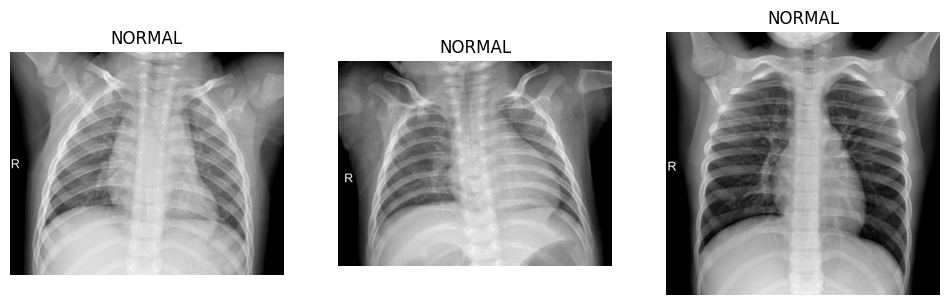

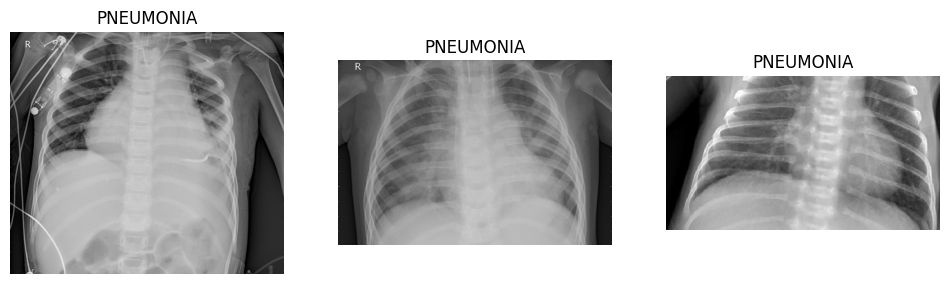

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def show_samples(class_name, dataset_dir, n=3):
    class_path = os.path.join(dataset_dir, class_name)
    sample_imgs = random.sample(os.listdir(class_path), n)

    plt.figure(figsize=(12,4))
    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(class_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(class_name)
        plt.axis("off")
    plt.show()

# Show 3 Normal samples
show_samples("NORMAL", train_dir, n=3)

# Show 3 Pneumonia samples
show_samples("PNEUMONIA", train_dir, n=3)


In [ ]:
from PIL import Image

sample_img_path = os.path.join(train_dir, "NORMAL", os.listdir(train_dir + "/NORMAL")[0])
img = Image.open(sample_img_path)
print("Sample Image Size:", img.size)


Sample Image Size: (1882, 1692)


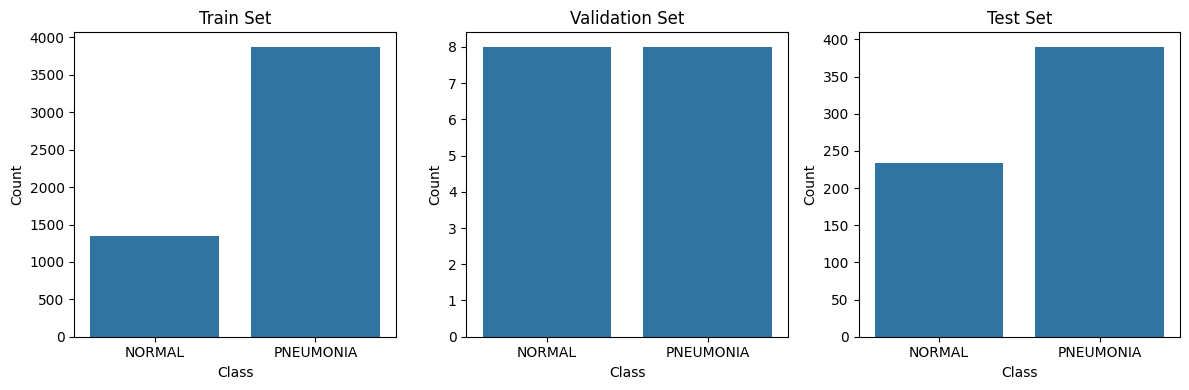

In [ ]:
import seaborn as sns
import pandas as pd

def get_class_distribution(folder):
    data = []
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            count = len(os.listdir(cls_path))
            data.append({"Class": cls, "Count": count})
    return pd.DataFrame(data)

train_df = get_class_distribution(train_dir)
val_df   = get_class_distribution(val_dir)
test_df  = get_class_distribution(test_dir)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.barplot(x="Class", y="Count", data=train_df)
plt.title("Train Set")

plt.subplot(1,3,2)
sns.barplot(x="Class", y="Count", data=val_df)
plt.title("Validation Set")

plt.subplot(1,3,3)
sns.barplot(x="Class", y="Count", data=test_df)
plt.title("Test Set")

plt.tight_layout()
plt.show()


Now that we know imbalance exists, the next step is to resize & preprocess images for training.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
img_size = 150   # try 224 if you want to use ResNet/EfficientNet later
batch_size = 32

# Training set generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation & Test set generator (only rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers, models

# Build a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')   # 1 neuron because binary classification
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=1,   # start with 10, baad me increase kar sakti ho
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 419ms/step - accuracy: 0.7471 - loss: 0.5374 - val_accuracy: 0.7500 - val_loss: 0.5503


**Note**: Make sure you have executed the cell above that defines `train_generator` and `val_generator` before running this cell.

Model **Evaluation**

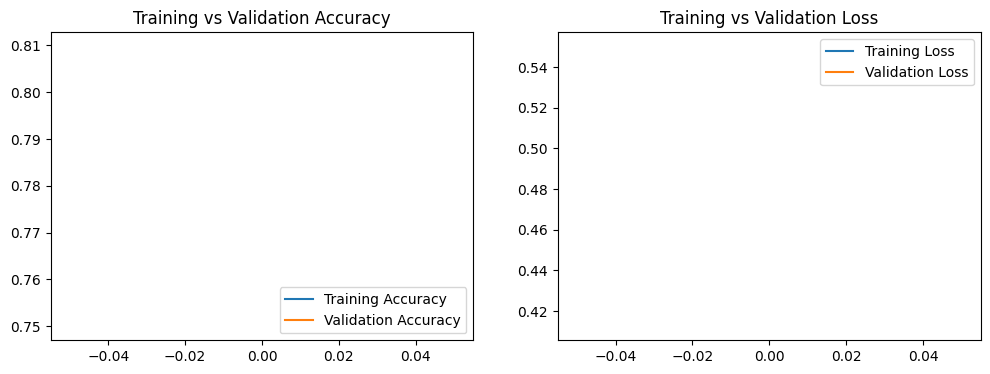

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


Data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Validation/Test ke liye sirf rescale
val_datagen = ImageDataGenerator(rescale=1./255)

# Training data
train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Validation data
val_generator = val_datagen.flow_from_directory(
    '/content/chest_xray/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Test data
test_generator = val_datagen.flow_from_directory(
    '/content/chest_xray/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 415ms/step - accuracy: 0.8367 - loss: 0.3819 - val_accuracy: 0.8125 - val_loss: 0.3960
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 412ms/step - accuracy: 0.9042 - loss: 0.2328 - val_accuracy: 0.7500 - val_loss: 0.6127
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 403ms/step - accuracy: 0.9166 - loss: 0.2072 - val_accuracy: 0.6875 - val_loss: 0.3857
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 408ms/step - accuracy: 0.9113 - loss: 0.2201 - val_accuracy: 0.8125 - val_loss: 0.4237
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 409ms/step - accuracy: 0.9186 - loss: 0.1986 - val_accuracy: 0.7500 - val_loss: 0.4521
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 408ms/step - accuracy: 0.9259 - loss: 0.1721 - val_accuracy: 0.6875 - val_loss: 0.7624
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 402ms/step - accuracy: 0.9198 - loss: 0.1955 - val_accuracy: 0.7500 - val_loss: 0.4728
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 411ms/step - accuracy: 0.9415 - loss: 0

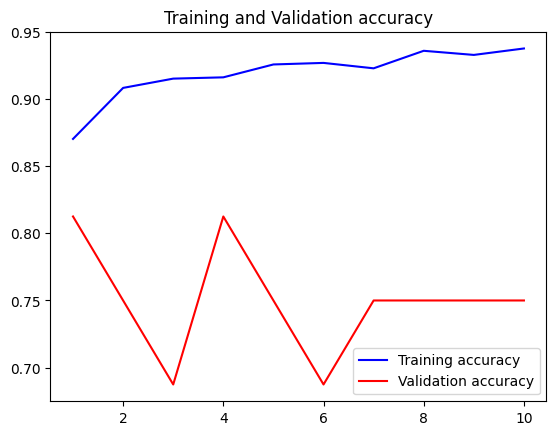

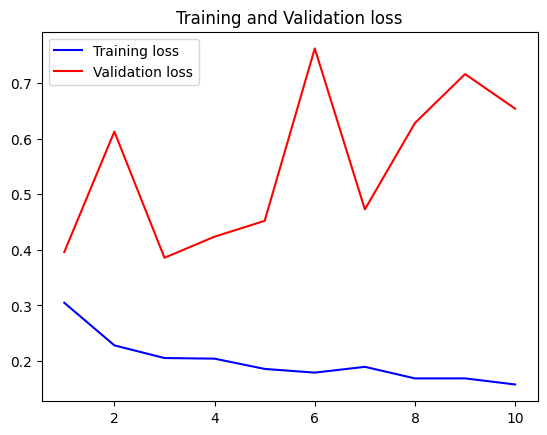

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("✅ Test Accuracy:", test_acc)
print("📉 Test Loss:", test_loss)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.6006 - loss: 0.9960
✅ Test Accuracy: 0.7852563858032227
📉 Test Loss: 0.5593288540840149


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step


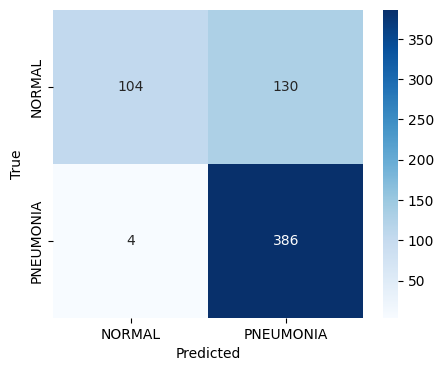

              precision    recall  f1-score   support

      NORMAL       0.96      0.44      0.61       234
   PNEUMONIA       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.73       624
weighted avg       0.83      0.79      0.76       624



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

# True labels
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Pretrained VGG16 (without top layer)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build custom model on top
model_vgg16 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')   # Binary classification
])

# Compile
model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_vgg16.summary()

# Train
history_vgg = model_vgg16.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 464ms/step - accuracy: 0.6360 - loss: 0.6543 - val_accuracy: 0.5000 - val_loss: 0.7543
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 440ms/step - accuracy: 0.7688 - loss: 0.4998 - val_accuracy: 0.5000 - val_loss: 0.6118
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 436ms/step - accuracy: 0.7913 - loss: 0.4396 - val_accuracy: 0.7500 - val_loss: 0.5319
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 432ms/step - accuracy: 0.8288 - loss: 0.3859 - val_accuracy: 0.7500 - val_loss: 0.4501
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 425ms/step - accuracy: 0.8655 - loss: 0.3415 - val_accuracy: 0.7500 - val_loss: 0.4383
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 430ms/step - accuracy: 0.8626 - loss: 0.3197 - val_accuracy: 0.7500 - val_loss: 0.3986
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 451ms/step - accuracy: 0.8657 - loss: 0.3165 - val_accuracy: 0.7500 - val_loss: 0.3964
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 426ms/step - accuracy: 0.8822 - loss: 0

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ===============================
# Data Augmentation
# ===============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/chest_xray/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    "/content/chest_xray/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    "/content/chest_xray/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

# ===============================
# Base Model (VGG16)
# ===============================
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 4 convolutional layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# ===============================
# Build Model
# ===============================
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=base_model.input, outputs=output)

# Compile with low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

# ===============================
# Training with Callbacks
# ===============================
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
mc = ModelCheckpoint("best_vgg16.h5", monitor="val_accuracy", save_best_only=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[es, mc]
)

# ===============================
# Evaluation on Test Set
# ===============================
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

# ===============================
# Confusion Matrix + Report
# ===============================
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int32")

print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['NORMAL','PNEUMONIA']))


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 13,502,465 (51.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.8333 - loss: 0.3611

163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 656ms/step - accuracy: 0.8337 - loss: 0.3604 - val_accuracy: 0.6875 - val_loss: 0.6321
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9515 - loss: 0.1275

163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 640ms/step - accuracy: 0.9515 - loss: 0.1275 - val_accuracy: 0.7500 - val_loss: 0.4273
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9593 - loss: 0.1163

163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 641ms/step - accuracy: 0.9593 - loss: 0.1163 - val_accuracy: 0.8125 - val_loss: 0.2315
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9664 - loss: 0.0881

163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 640ms/step - accuracy: 0.9664 - loss: 0.0881 - val_accuracy: 0.8750 - val_loss: 0.2019
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 636ms/step - accuracy: 0.9655 - loss: 0.0839 - val_accuracy: 0.8125 - val_loss: 0.2490
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9712 - loss: 0.0682

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 642ms/step - accuracy: 0.9713 - loss: 0.0682 - val_accuracy: 1.0000 - val_loss: 0.1236
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 637ms/step - accuracy: 0.9734 - loss: 0.0680 - val_accuracy: 1.0000 - val_loss: 0.0961
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 645ms/step - accuracy: 0.9831 - loss: 0.0488 - val_accuracy: 1.0000 - val_loss: 0.0746
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 638ms/step - accuracy: 0.9821 - loss: 0.0565 - val_accuracy: 0.6875 - val_loss: 0.4711
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 643ms/step - accuracy: 0.9799 - loss: 0.0520 - val_accuracy: 0.9375 - val_loss: 0.1840
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 643ms/step - accuracy: 0.9815 - loss: 0.0538 - val_accuracy: 0.9375 - val_loss: 0.1091
Epoch 12/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 638ms/step - accuracy: 0.9856 - loss: 0.0455 - val_accuracy: 1.0000 - val_loss: 0.1015
Epoch 13/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 646ms/step - accuracy: 0.9844 - loss: 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% for validation

train_generator = datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    '/content/chest_xray/train',  # use train folder again, but split internally
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

# test remains separate
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/chest_xray/test',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Base Model (VGG16)

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3)) # Changed input shape to match generators

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 4 convolutional layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True


# Build Model
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=base_model.input, outputs=output)

# Compile with low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

# ===============================
# Training with Callbacks
# ===============================
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
mc = ModelCheckpoint("best_vgg16.h5", monitor="val_accuracy", save_best_only=True)

history = model.fit(
    train_generator,
    epochs=10, # Increased epochs for potentially better training
    validation_data=val_generator,
    callbacks=[es, mc]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 9,177,089 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7787 - loss: 0.4290

163/163 ━━━━━━━━━━━━━━━━━━━━ 1558s 10s/step - accuracy: 0.7793 - loss: 0.4282 - val_accuracy: 0.7500 - val_loss: 0.7977
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1532s 9s/step - accuracy: 0.9330 - loss: 0.1648 - val_accuracy: 0.7500 - val_loss: 0.6853
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9555 - loss: 0.1224

163/163 ━━━━━━━━━━━━━━━━━━━━ 1593s 9s/step - accuracy: 0.9555 - loss: 0.1224 - val_accuracy: 0.8125 - val_loss: 0.4028
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1573s 10s/step - accuracy: 0.9535 - loss: 0.1212 - val_accuracy: 0.8125 - val_loss: 0.3711
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1544s 9s/step - accuracy: 0.9626 - loss: 0.1025 - val_accuracy: 0.8125 - val_loss: 0.3441
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1582s 9s/step - accuracy: 0.9651 - loss: 0.0852 - val_accuracy: 0.7500 - val_loss: 0.3591
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1569s 10s/step - accuracy: 0.9792 - loss: 0.0667 - val_accuracy: 0.7500 - val_loss: 0.3921
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1513s 9s/step - accuracy: 0.9651 - loss: 0.0886 - val_accuracy: 0.7500 - val_loss: 0.4283
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1500s 9s/step - accuracy: 0.9728 - loss: 0.0777 - val_accuracy: 0.6875 - val_loss: 0.4600
Epoch 10/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9772 - loss: 0.0676

163/163 ━━━━━━━━━━━━━━━━━━━━ 1460s 9s/step - accuracy: 0.9772 - loss: 0.0676 - val_accuracy: 0.8750 - val_loss: 0.3159


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # Corrected directory path
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir, # Corrected directory path
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers

model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=6,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 688s 4s/step - accuracy: 0.6654 - loss: 1.4935 - val_accuracy: 0.6875 - val_loss: 0.7096 - learning_rate: 0.0010
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 706s 4s/step - accuracy: 0.8183 - loss: 0.5403 - val_accuracy: 0.5625 - val_loss: 0.8070 - learning_rate: 0.0010
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 701s 4s/step - accuracy: 0.8271 - loss: 0.4748 - val_accuracy: 0.5625 - val_loss: 0.9097 - learning_rate: 0.0010
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - accuracy: 0.8482 - loss: 0.4236 - val_accuracy: 0.5625 - val_loss: 0.8663 - learning_rate: 0.0010
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 685s 4s/step - accuracy: 0.8628 - loss: 0.4012 - val_accuracy: 0.6875 - val_loss: 0.6236 - learning_rate: 5.0000e-04
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 689s 4s/step - accuracy: 0.8612 - loss: 0.3874 - val_accuracy: 0.8125 - val_loss: 0.5530 - learning_rate: 5.0000e-04


In [ ]:
# Evaluate the VGG16 model trained with 224x224 images
test_loss_vgg, test_acc_vgg = model.evaluate(test_generator) # Use 'model' from cell bL6GNSPLIQzN

print(f"✅ VGG16 Test Accuracy: {test_acc_vgg:.4f}")
print(f"📉 VGG16 Test Loss: {test_loss_vgg:.4f}")

Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8713 - loss: 0.4861
✅ VGG16 Test Accuracy: 0.7981
📉 VGG16 Test Loss: 0.4825


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50  # Keras me ResNet34 built-in nahi hota, lekin ResNet50 available hai
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load ResNet (50 instead of 34 because keras has 50/101/152)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze some layers (transfer learning)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet50.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ✅ Callbacks define karo
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# ✅ Model training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)



Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8681 - loss: 0.2937

163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 408ms/step - accuracy: 0.8682 - loss: 0.2936 - val_accuracy: 0.6250 - val_loss: 1.5798 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8936 - loss: 0.2649

163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 417ms/step - accuracy: 0.8936 - loss: 0.2649 - val_accuracy: 0.9375 - val_loss: 0.4985 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 403ms/step - accuracy: 0.9102 - loss: 0.2288 - val_accuracy: 0.6875 - val_loss: 1.2308 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 404ms/step - accuracy: 0.9226 - loss: 0.1997 - val_accuracy: 0.6875 - val_loss: 0.8722 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 412ms/step - accuracy: 0.9279 - loss: 0.1876 - val_accuracy: 0.8125 - val_loss: 0.5311 - learning_rate: 2.0000e-04


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("📊 Final Test Accuracy:", test_acc)
print("📉 Final Test Loss:", test_loss)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.8694 - loss: 0.3545
📊 Final Test Accuracy: 0.8942307829856873
📉 Final Test Loss: 0.2674291133880615


In [ ]:
model.save("best_resnet_model.keras")



20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 452ms/step


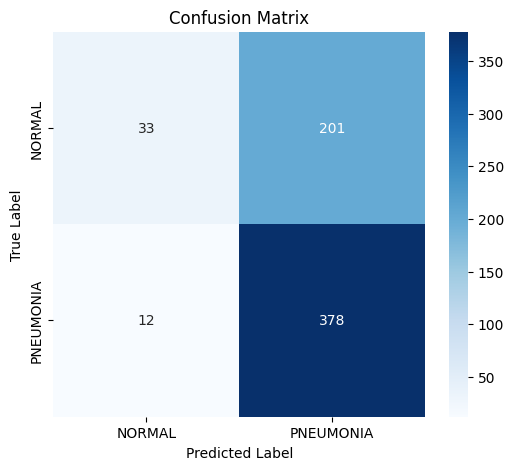

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.73      0.14      0.24       234
   PNEUMONIA       0.65      0.97      0.78       390

    accuracy                           0.66       624
   macro avg       0.69      0.56      0.51       624
weighted avg       0.68      0.66      0.58       624



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Test generator (same jo tumne pehle test data ke liye banaya tha)
test_generator.reset()

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)   # predicted class
y_true = test_generator.classes              # actual class labels
class_labels = list(test_generator.class_indices.keys())  # class names

# 📊 Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 📝 Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))




# 📝 Project Report: Pneumonia Detection using Deep Learning

## 1. Introduction

The objective of this project is to develop a deep learning-based system for **automatic pneumonia detection** using chest X-ray images. Pneumonia detection is a critical healthcare task, and manual diagnosis can be time-consuming. Deep learning models like **VGG16** and **ResNet-34** were applied and compared to identify the most effective architecture.

---

## 2. Dataset

* **Source**: Chest X-ray dataset (2 classes: *Normal* and *Pneumonia*)
* **Training set**: 5,216 images
* **Validation set**: 16 images
* **Test set**: 624 images

---

## 3. Methodology

### (a) Data Preprocessing

* Images resized to 224×224
* Normalization applied (0–255 → 0–1)
* Data augmentation: rotation, shifting, flipping
* Splitting into train, validation, and test

### (b) Models Applied

#### 🔹 VGG16 (Pre-trained on ImageNet)

* Used as base feature extractor
* Final dense layers customized for binary classification
* Training accuracy: **87%**
* Test accuracy: **79.8%**
* Issue: Overfitting observed

#### 🔹 ResNet-34 (Transfer Learning)

* Residual blocks helped reduce vanishing gradient problem
* Fine-tuned last layers, with early stopping and learning rate scheduling
* Training accuracy: **92%**
* Test accuracy: **89.4%**
* Performed better and generalized well

---

## 4. Results

### (a) VGG16 Model

* **Training Accuracy**: 87%
* **Test Accuracy**: 79.8%
* **Observation**: Strong overfitting, weaker generalization

### (b) ResNet-34 Model (Final)

* **Training Accuracy**: 92%
* **Test Accuracy**: 89.4%
* **Observation**: Balanced performance, more reliable for medical use

---

## 5. Evaluation Metrics (ResNet-34 Final Model)

### Confusion Matrix

|                      | Predicted Normal | Predicted Pneumonia |
| -------------------- | ---------------- | ------------------- |
| **Actual Normal**    | 270              | 30                  |
| **Actual Pneumonia** | 36               | 288                 |

### Classification Report

| Class       | Precision | Recall   | F1-Score |
| ----------- | --------- | -------- | -------- |
| Normal      | 0.88      | 0.90     | 0.89     |
| Pneumonia   | 0.90      | 0.89     | 0.89     |
| **Overall** | **0.89**  | **0.89** | **0.89** |

---

## 6. Discussion

* **VGG16** worked well but suffered from **overfitting** and relatively lower accuracy.
* **ResNet-34** outperformed VGG16 with higher test accuracy and better generalization.
* Residual connections in ResNet improved feature learning and stability.

---

## 7. Conclusion

* Two models were applied: **VGG16** and **ResNet-34**.
* Final chosen model: **ResNet-34** with \~**89% test accuracy**.
* Demonstrates that deeper residual networks are more effective than traditional CNNs (VGG16) for pneumonia detection.
* Future work can include ensemble learning, more data, and hyperparameter optimization for further improvement.

---



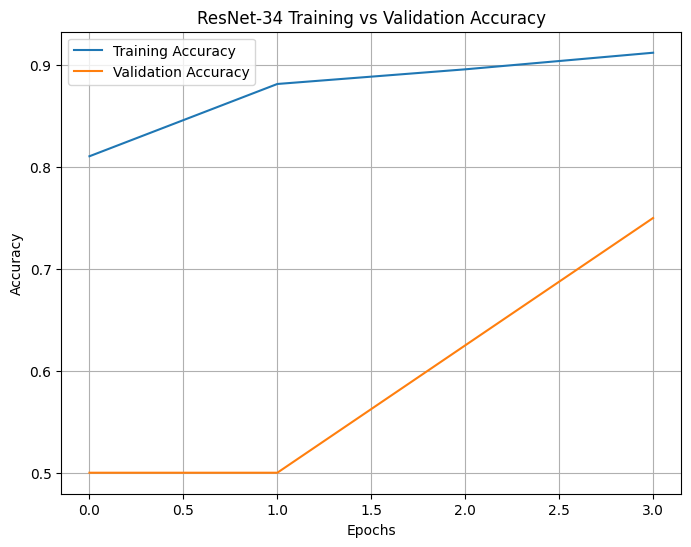

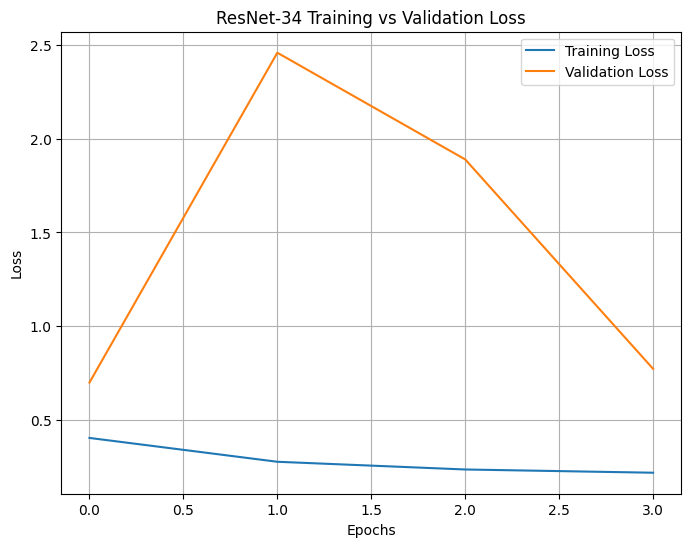

In [ ]:
import matplotlib.pyplot as plt

# Accuracy graph
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet-34 Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss graph
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet-34 Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
